In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras_pyramid_pooling_module import PyramidPoolingModule

In [2]:
np.random.seed(222)
tf.random.set_seed(222)

In [3]:
def plot_image_grid(data, figsize=(15, 15), cmap=None, cbar=True):
    """
    Plot the data as a grid of images.

    Args:
        data: the tensor of image data to plot in
        (M, N, H, W, C) format where M is the 
        height of the image grid, N is the width
        of the image grid, H is the height of the
        image, W is the width of the image, and C
        is the channel dimensionality of the image
        cmap: the color map to use for the data
        cbar: whether to include a color bar legend

    Returns:
        None

    """
    M, N = data.shape[0], data.shape[1]
    fig, ax = plt.subplots(nrows=M, ncols=N, sharex=True, sharey=True, figsize=figsize)
    for i in range(M):    
        for j in range(N): 
            idx = i + 1 + N * j
            im = ax[i, j].imshow(data[i, j], cmap=cmap)
            ax[i, j].axes.xaxis.set_major_locator(plt.NullLocator())
            ax[i, j].axes.yaxis.set_major_locator(plt.NullLocator())
    if cbar:
        cb_ax = fig.add_axes([1., 0.2, 0.02, 0.6])
        cbar = fig.colorbar(im, cax=cb_ax)

# Dataset

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# normalize images into [0, 1]
X_train = X_train[..., None] / 255.0
X_test = X_test[..., None] / 255.0
# get the target size of the images and number of classes
TARGET_SIZE = X_train.shape[1:]
NUM_CLASSES = np.max(y_train) + 1
# convert discrete labels to one-hot vectors
y_train = np.eye(NUM_CLASSES)[y_train.flatten()]
y_test = np.eye(NUM_CLASSES)[y_test.flatten()]

In [5]:
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

In [6]:
X_test.shape, y_test.shape

((10000, 28, 28, 1), (10000, 10))

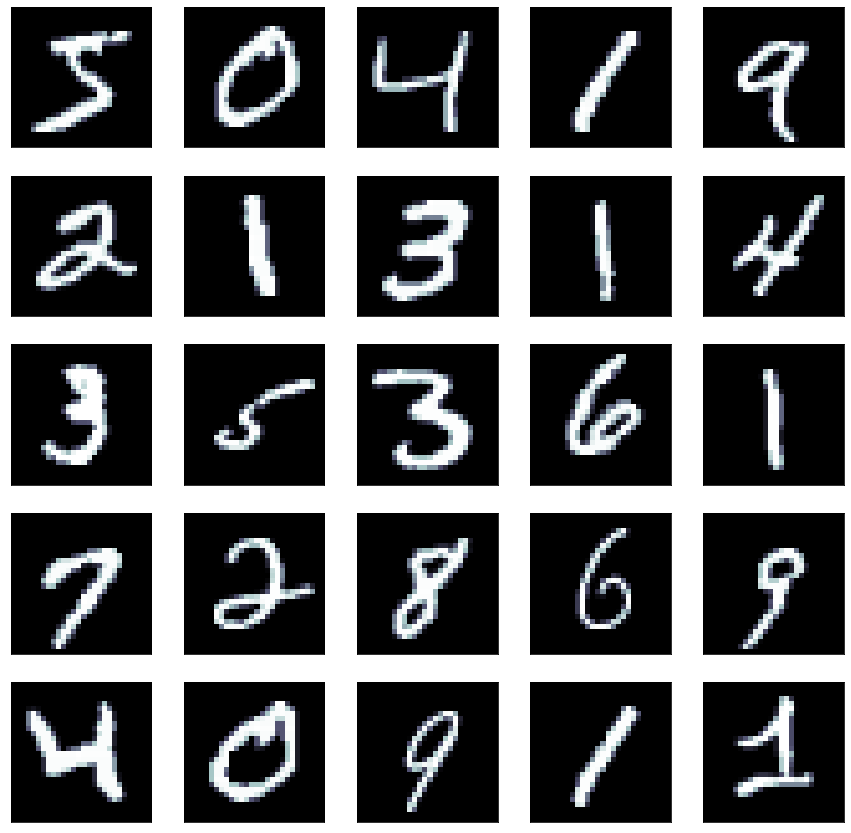

In [7]:
plot_image_grid(X_train[:25].reshape(5, 5, 28, 28, 1), cbar=False, cmap='bone')

# Model

## Baseline

In [8]:
input_layer = Input(TARGET_SIZE)
x = input_layer
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0     

In [9]:
history1 = model.fit(X_train, y_train, 
    epochs=5, 
    batch_size=10, 
    validation_split=0.3,
    shuffle=True,
)

Epoch 1/5
4200/4200 [==============================] - 24s 5ms/step - loss: 1.0363 - accuracy: 0.8894 - val_loss: 0.5280 - val_accuracy: 0.9577
Epoch 2/5
4200/4200 [==============================] - 22s 5ms/step - loss: 0.3822 - accuracy: 0.9657 - val_loss: 0.3016 - val_accuracy: 0.9750
Epoch 3/5
4200/4200 [==============================] - 22s 5ms/step - loss: 0.1911 - accuracy: 0.9770 - val_loss: 0.2256 - val_accuracy: 0.9746
Epoch 4/5
4200/4200 [==============================] - 22s 5ms/step - loss: 0.1211 - accuracy: 0.9817 - val_loss: 0.1681 - val_accuracy: 0.9783
Epoch 5/5
4200/4200 [==============================] - 22s 5ms/step - loss: 0.0876 - accuracy: 0.9845 - val_loss: 0.1449 - val_accuracy: 0.9794


In [10]:
df1 = pd.DataFrame(history1.history)
df1

,loss,accuracy,val_loss,val_accuracy
0,0.730389,0.933690,0.527965,0.957722
1,0.357683,0.967238,0.301606,0.975000
2,0.196190,0.976548,0.225586,0.974611
3,0.125315,0.982000,0.168055,0.978333
4,0.086145,0.984452,0.144884,0.979444


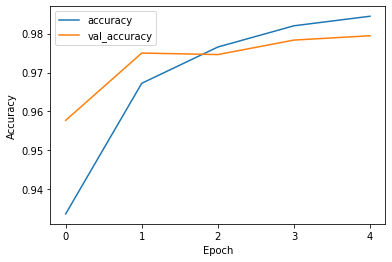

In [11]:
ax = df1[[c for c in df1.columns if 'accuracy' in c]].plot()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

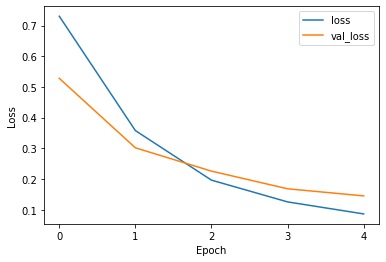

In [12]:
ax = df1[[c for c in df1.columns if 'loss' in c]].plot()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [13]:
loss1, accuracy1 = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1247 - accuracy: 0.9811


## Pyramid Pooling Near Output

In [14]:
input_layer = Input(TARGET_SIZE)
x = input_layer
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = PyramidPoolingModule(1, (3, 3), padding='same')(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 64)        0   

In [15]:
history2 = model.fit(X_train, y_train, 
    epochs=5, 
    batch_size=10, 
    validation_split=0.3,
    shuffle=True,
)

Epoch 1/5
4200/4200 [==============================] - 62s 15ms/step - loss: 1.1654 - accuracy: 0.8886 - val_loss: 1.4213 - val_accuracy: 0.9036
Epoch 2/5
4200/4200 [==============================] - 62s 15ms/step - loss: 0.3783 - accuracy: 0.9675 - val_loss: 0.3695 - val_accuracy: 0.9621
Epoch 3/5
4200/4200 [==============================] - 62s 15ms/step - loss: 0.1888 - accuracy: 0.9779 - val_loss: 0.2742 - val_accuracy: 0.9699
Epoch 4/5
4200/4200 [==============================] - 59s 14ms/step - loss: 0.1376 - accuracy: 0.9816 - val_loss: 0.1814 - val_accuracy: 0.9771
Epoch 5/5
4200/4200 [==============================] - 61s 15ms/step - loss: 0.1048 - accuracy: 0.9850 - val_loss: 0.1591 - val_accuracy: 0.9776


In [16]:
df2 = pd.DataFrame(history2.history)
df2

,loss,accuracy,val_loss,val_accuracy
0,0.830301,0.931929,1.421297,0.903556
1,0.345971,0.969452,0.369487,0.962111
2,0.195125,0.977500,0.274207,0.969889
3,0.134800,0.981500,0.181444,0.977056
4,0.097198,0.985143,0.159130,0.977611


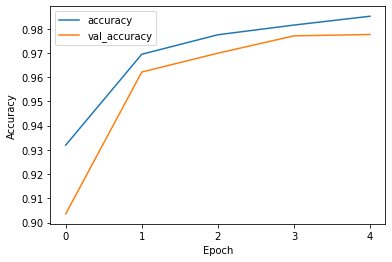

In [17]:
ax = df2[[c for c in df2.columns if 'accuracy' in c]].plot()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

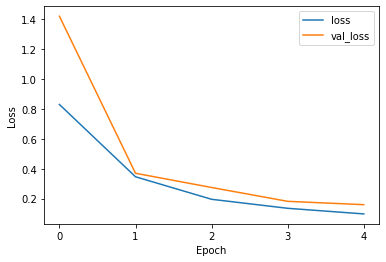

In [18]:
ax = df2[[c for c in df2.columns if 'loss' in c]].plot()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [19]:
loss2, accuracy2 = model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 13ms/step - loss: 0.1612 - accuracy: 0.9758


## Pyramid Pooling Near Input

In [20]:
input_layer = Input(TARGET_SIZE)
x = input_layer
x = PyramidPoolingModule(1, (3, 3), padding='same')(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
pyramid_pooling_module_1 (Py (None, 28, 28, 5)         40        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        1344      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        16448     
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 64)        256 

In [21]:
history3 = model.fit(X_train, y_train, 
    epochs=5, 
    batch_size=10, 
    validation_split=0.3,
    shuffle=True,
)

Epoch 1/5
4200/4200 [==============================] - 25s 6ms/step - loss: 1.1626 - accuracy: 0.8914 - val_loss: 0.4190 - val_accuracy: 0.9671
Epoch 2/5
4200/4200 [==============================] - 25s 6ms/step - loss: 0.3462 - accuracy: 0.9687 - val_loss: 0.2900 - val_accuracy: 0.9728
Epoch 3/5
4200/4200 [==============================] - 25s 6ms/step - loss: 0.1931 - accuracy: 0.9782 - val_loss: 0.2318 - val_accuracy: 0.9707
Epoch 4/5
4200/4200 [==============================] - 25s 6ms/step - loss: 0.1179 - accuracy: 0.9816 - val_loss: 0.1585 - val_accuracy: 0.9780
Epoch 5/5
4200/4200 [==============================] - 25s 6ms/step - loss: 0.0905 - accuracy: 0.9860 - val_loss: 0.1294 - val_accuracy: 0.9795


In [22]:
df3 = pd.DataFrame(history3.history)
df3

,loss,accuracy,val_loss,val_accuracy
0,0.756108,0.935476,0.419033,0.967056
1,0.325693,0.969071,0.289967,0.972833
2,0.191694,0.978024,0.231812,0.970722
3,0.120559,0.981667,0.158528,0.978000
4,0.089881,0.984857,0.129442,0.979500


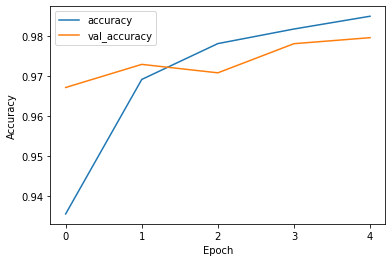

In [23]:
ax = df3[[c for c in df3.columns if 'accuracy' in c]].plot()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

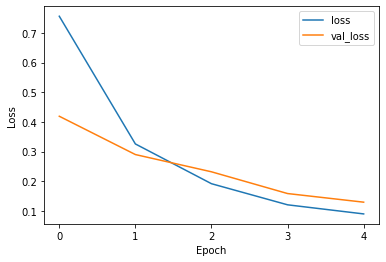

In [24]:
ax = df3[[c for c in df3.columns if 'loss' in c]].plot()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

In [25]:
loss3, accuracy3 = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1014 - accuracy: 0.9824


## Comparisons

In [26]:
loss1, loss2, loss3 = 0.001, 0.0002, 0.0004
accuracy1, accuracy2, accuracy3 = 0.96, 0.95, 0.98

In [27]:
df = pd.DataFrame([[loss1, loss2, loss3], [accuracy1, accuracy2, accuracy3]]).T
df.columns = ['Loss', 'Accuracy']
df.index = ['Baselines', 'Pyramind Near Output', 'Pyramid Near Input']
df

,Loss,Accuracy
Baselines,0.0010,0.96
Pyramind Near Output,0.0002,0.95
Pyramid Near Input,0.0004,0.98


Text(0.5, 0, 'Architecture')

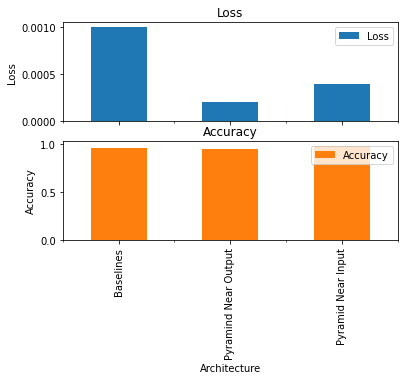

In [28]:
ax = df.plot(kind='bar', subplots=True)
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Architecture')